In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import albumentations as A
import matplotlib.pyplot as plt

# ====================
# CONFIGURATION
# ====================
BASE_PATH = r"C:\Users\Shafi.09\AnocondaProjects\BrainT\R_datasets"
PREPROCESSED_PATH = os.path.join(BASE_PATH, "preprocessed_masoud_nickparvar_dataset")
LABELS = ['glioma', 'meningioma', 'pituitary', 'notumor']
IMAGE_SIZE = 256
VAL_SPLIT = 0.3  # 30% of training data for validation
RANDOM_STATE = 42

# Enable mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print("Mixed precision enabled. Computations will use float16 where possible.")

# ====================
# DATA LOADING & PREPROCESSING (Optimized for memory)
# ====================
def mri_preprocessing(image):
    """Enhanced MRI-specific preprocessing with float32 conversion"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Noise reduction
    blurred = cv2.medianBlur(enhanced, 3)
    
    # Resize and normalize with float32 conversion
    processed = cv2.resize(blurred, (IMAGE_SIZE, IMAGE_SIZE))
    processed = processed.astype(np.float32) / 255.0  # Convert to float32
    return np.expand_dims(processed, axis=-1)  # Add channel dimension

def load_data(directory):
    X, Y = [], []
    for label in LABELS:
        folder_path = os.path.join(directory, label)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
            if img is not None:
                processed = mri_preprocessing(img)
                X.append(processed)
                Y.append(label)
    return np.array(X), np.array(Y)

# Load ALL training data
print("Loading training data...")
X_train_all, Y_train_all = load_data(os.path.join(PREPROCESSED_PATH, "Training"))

# Load test data
print("Loading test data...")
X_test, Y_test = load_data(os.path.join(PREPROCESSED_PATH, "Testing"))

# Split training data into train and validation sets
print(f"Splitting training data (validation: {VAL_SPLIT*100}%)...")
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_all, Y_train_all, 
    test_size=VAL_SPLIT, 
    stratify=Y_train_all,
    random_state=RANDOM_STATE
)

# Encode labels with float32 conversion
def encode_labels(Y):
    return tf.keras.utils.to_categorical(
        [LABELS.index(y) for y in Y], 
        num_classes=len(LABELS),
        dtype=np.float32  # Critical: use float32 here
    )

Y_train = encode_labels(Y_train)
Y_val = encode_labels(Y_val)
Y_test = encode_labels(Y_test)

# Shuffle training data
X_train, Y_train = shuffle(X_train, Y_train, random_state=RANDOM_STATE)



INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
Mixed precision enabled. Computations will use float16 where possible.
Loading training data...
Loading test data...
Splitting training data (validation: 30.0%)...


In [2]:
# ====================
# DATA AUGMENTATION (Optimized)
# ====================
def augment_images(images: np.ndarray) -> np.ndarray:
    """Conservative MRI augmentation preserving diagnostic features"""
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        A.RandomGamma(gamma_limit=(80, 120))
    ])

    aug_images = []
    for img in images:
        # Ensure input is uint8 for albumentations
        input_img = (img[..., 0] * 255).astype(np.uint8)
        augmented = transform(image=input_img)['image']
        # Convert back to float32 after augmentation
        augmented = augmented.astype(np.float32) / 255.0
        aug_images.append(augmented[..., np.newaxis]) 
    
    return np.array(aug_images)

print("\nAugmenting training data...")
X_train_aug = augment_images(X_train)
Y_train_aug = Y_train.copy()

# Combine and shuffle FINAL training set (with memory optimization)
print("Combining datasets...")
X_train_final = np.concatenate([X_train, X_train_aug], axis=0).astype(np.float32)
Y_train_final = np.concatenate([Y_train, Y_train_aug], axis=0).astype(np.float32)


print("Shuffling final dataset...")
X_train_final, Y_train_final = shuffle(X_train_final, Y_train_final, random_state=RANDOM_STATE)

print(f"Original training samples: {len(X_train_final)//2}")
print(f"Augmented training samples: {len(X_train_final)//2}")
print(f"Final training samples: {len(X_train_final)}")

# ====================
# DATASET ANALYSIS
# ====================
def print_class_distribution(Y, dataset_name):
    class_counts = np.sum(Y, axis=0)
    print(f"\n{dataset_name} class distribution:")
    for i, label in enumerate(LABELS):
        print(f"{label}: {int(class_counts[i])} samples")
    print(f"Total: {len(Y)} samples")

def print_shapes():
    print("\nDataset Shapes:")
    print(f"FINAL TRAINING SET: X_train_final: {X_train_final.shape}, Y_train_final: {Y_train_final.shape}")
    print(f"Validation set: X_val: {X_val.shape}, Y_val: {Y_val.shape}")
    print(f"Test set: X_test: {X_test.shape}, Y_test: {Y_test.shape}")

print_class_distribution(Y_train_final, "Final Training Set")
print_class_distribution(Y_val, "Validation Set")
print_class_distribution(Y_test, "Test Set")
print_shapes()

# Verify data types
print("\nData types:")
print(f"X_train_final: {X_train_final.dtype}, Y_train_final: {Y_train_final.dtype}")
print(f"X_val: {X_val.dtype}, Y_val: {Y_val.dtype}")
print(f"X_test: {X_test.dtype}, Y_test: {Y_test.dtype}")


Augmenting training data...
Combining datasets...
Shuffling final dataset...
Original training samples: 3864
Augmented training samples: 3864
Final training samples: 7728

Final Training Set class distribution:
glioma: 1850 samples
meningioma: 1866 samples
pituitary: 2022 samples
notumor: 1990 samples
Total: 7728 samples

Validation Set class distribution:
glioma: 396 samples
meningioma: 400 samples
pituitary: 434 samples
notumor: 427 samples
Total: 1657 samples

Test Set class distribution:
glioma: 299 samples
meningioma: 302 samples
pituitary: 295 samples
notumor: 309 samples
Total: 1205 samples

Dataset Shapes:
FINAL TRAINING SET: X_train_final: (7728, 256, 256, 1), Y_train_final: (7728, 4)
Validation set: X_val: (1657, 256, 256, 1), Y_val: (1657, 4)
Test set: X_test: (1205, 256, 256, 1), Y_test: (1205, 4)

Data types:
X_train_final: float32, Y_train_final: float32
X_val: float32, Y_val: float32
X_test: float32, Y_test: float32



DATASET DISTRIBUTION VISUALIZATION


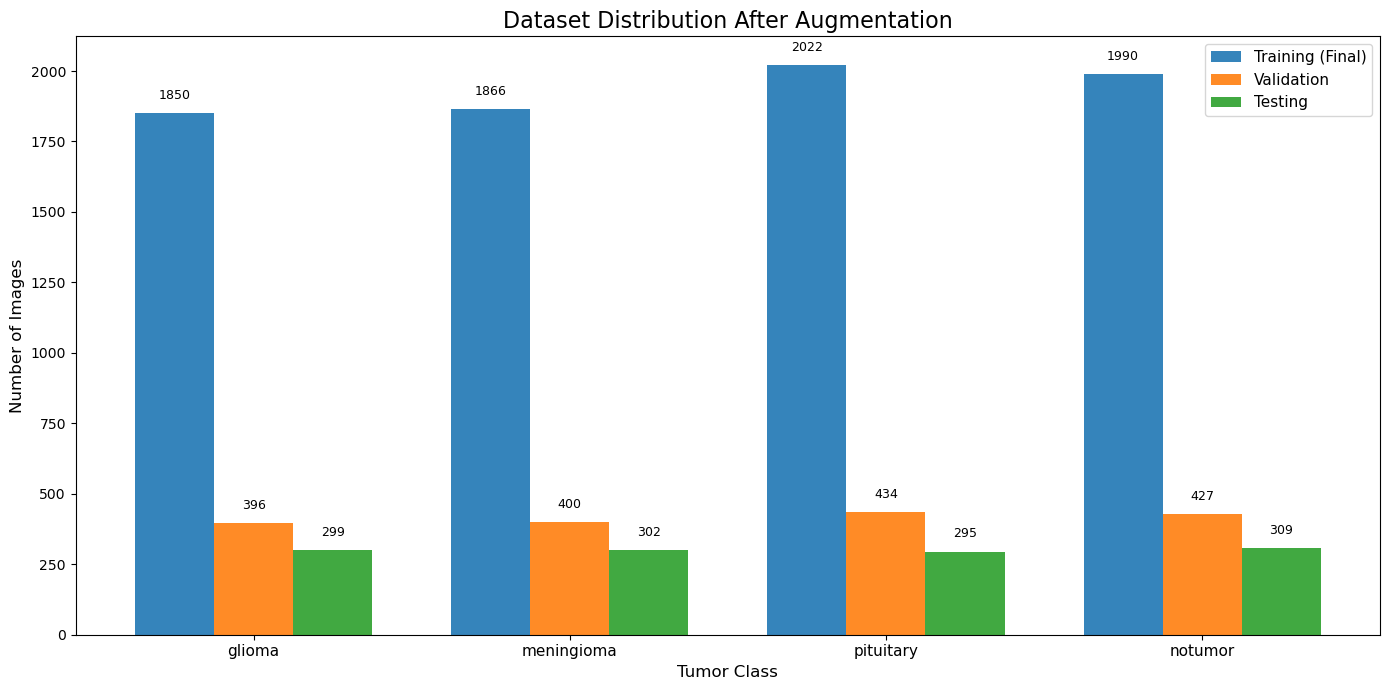


SAMPLE IMAGE VISUALIZATION
Final Training Set Samples:


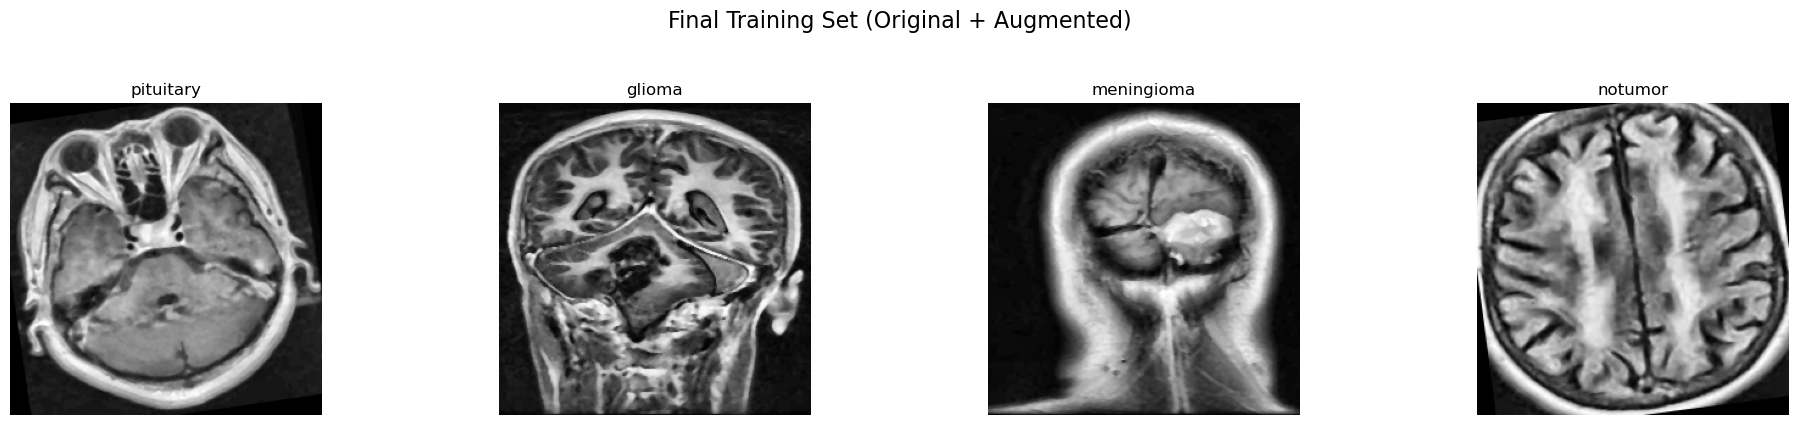


Validation Set Samples:


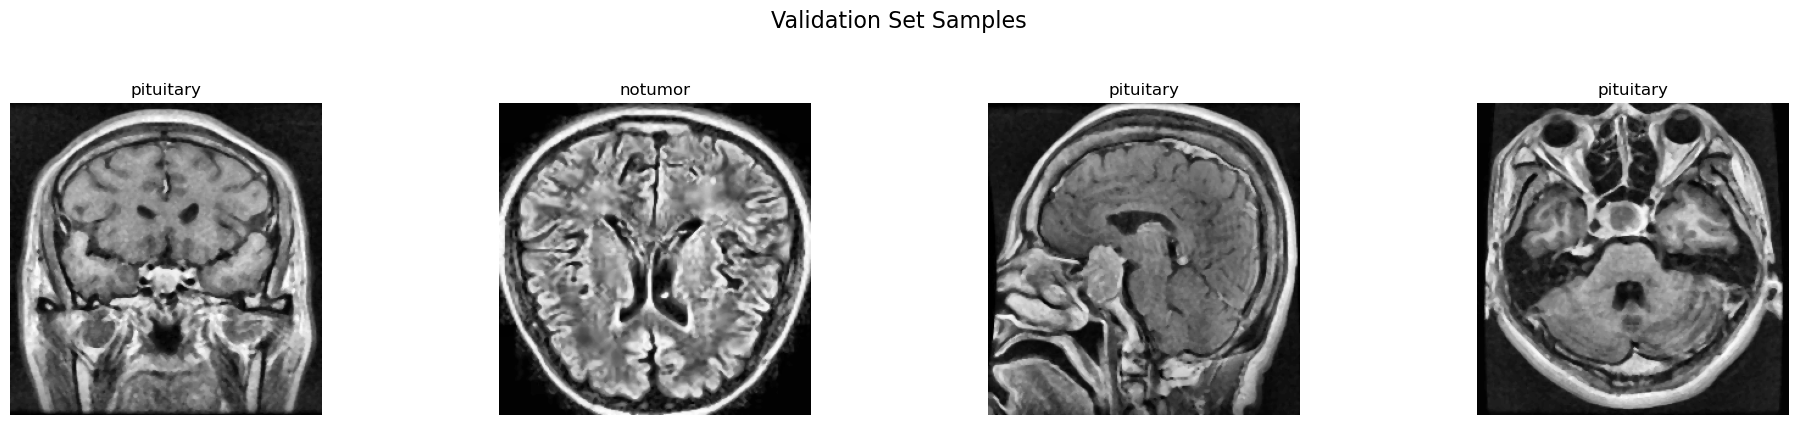


Test Set Samples:


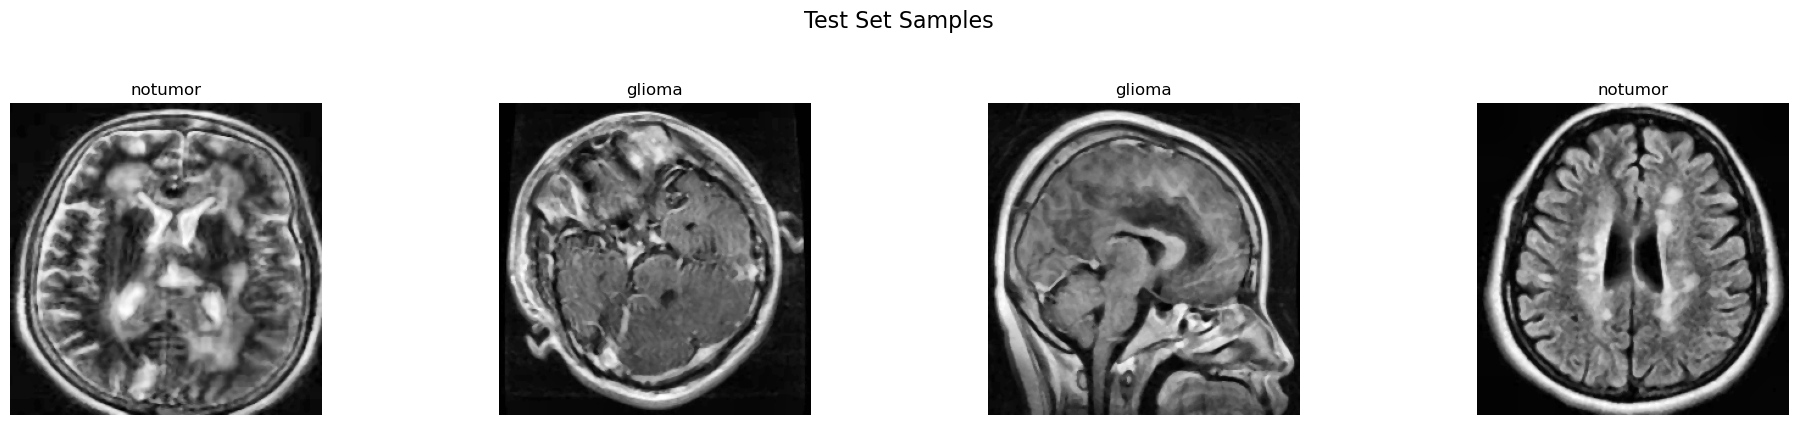


INTENSITY HISTOGRAM ANALYSIS
Training Set Intensity Distribution:


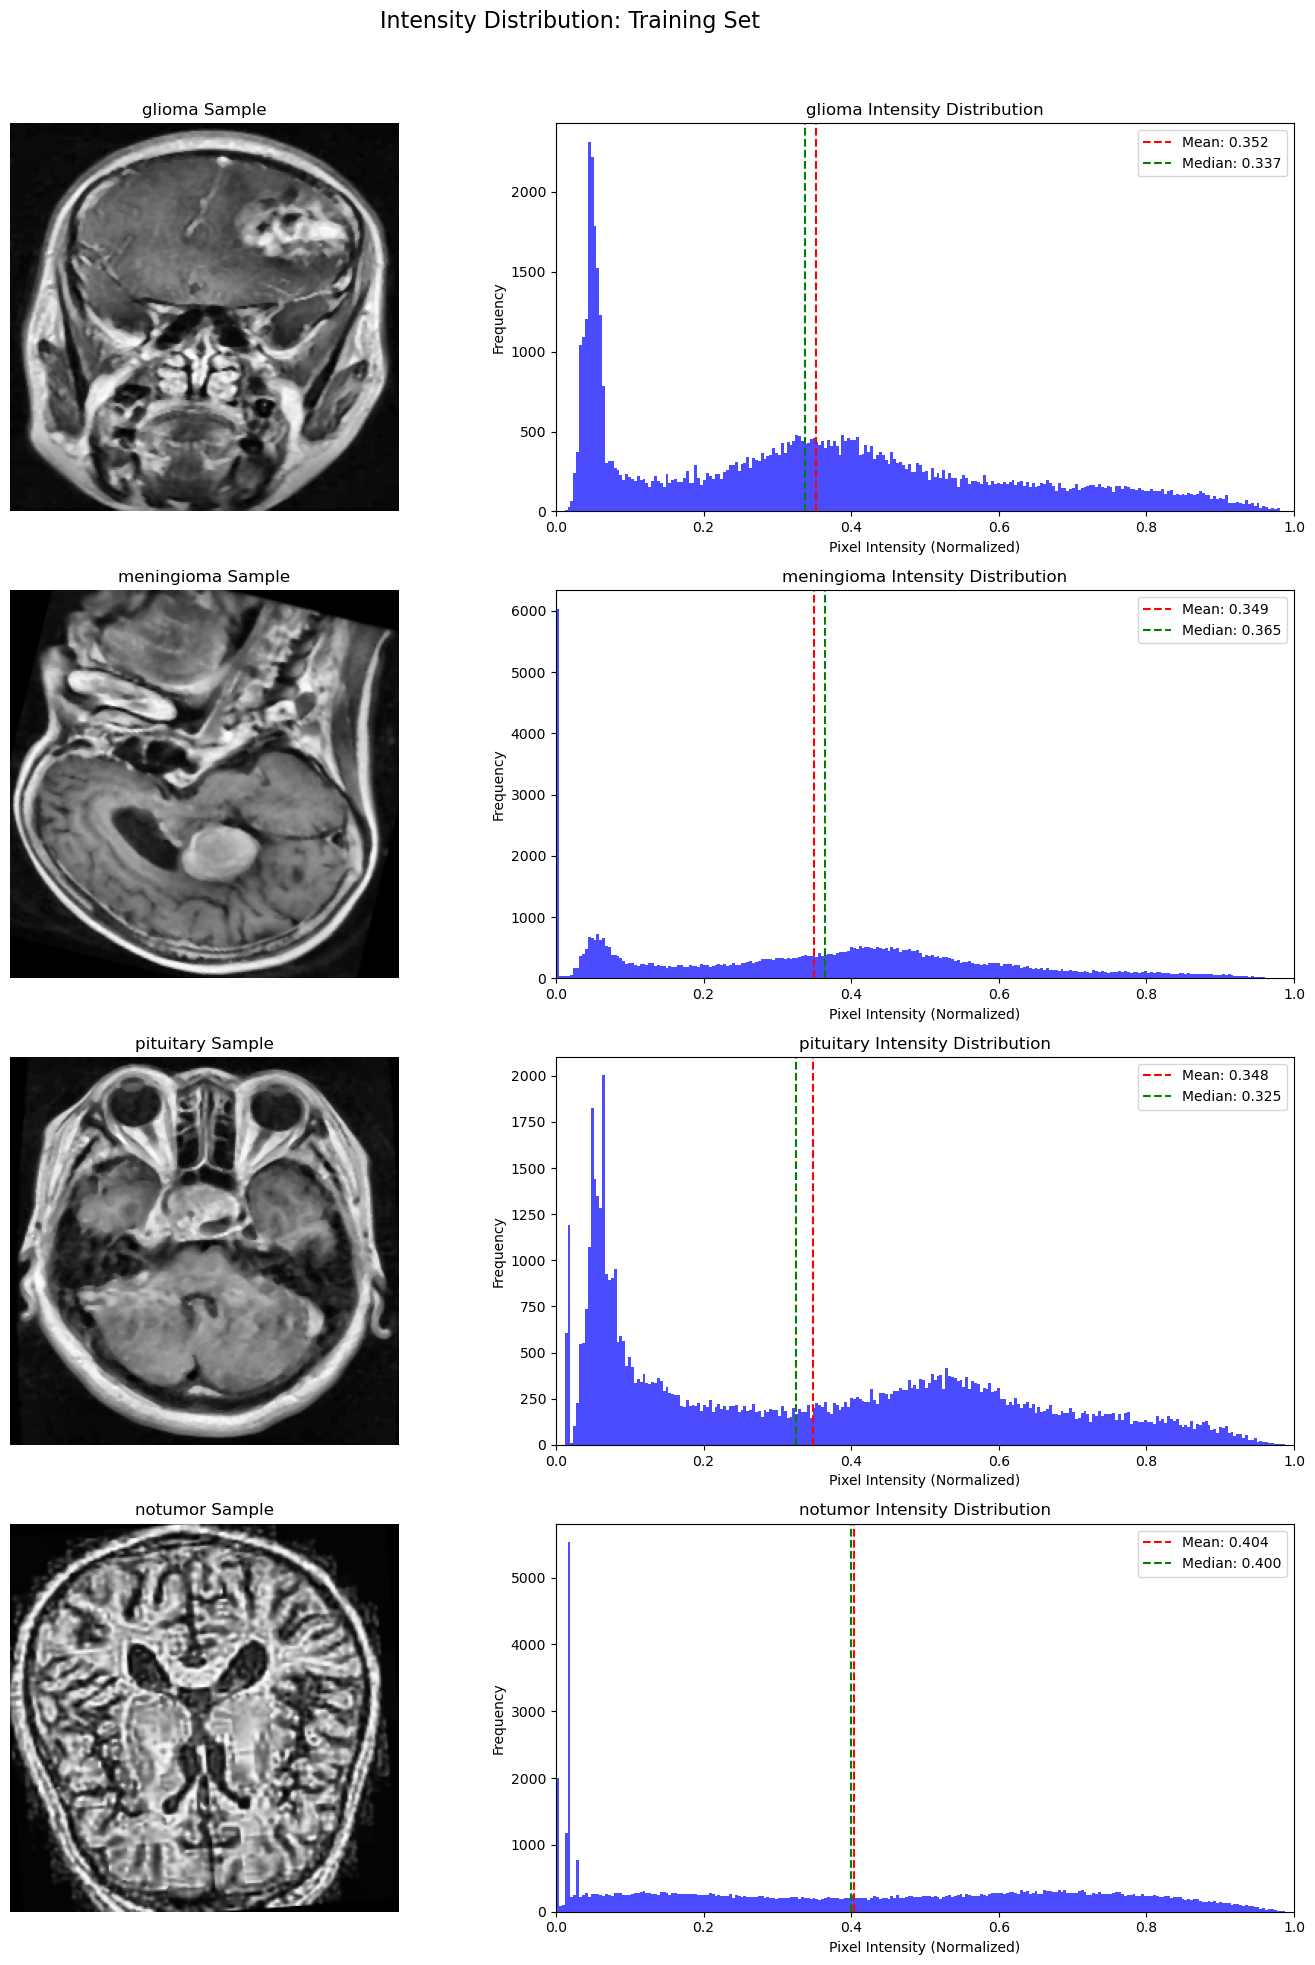


Validation Set Intensity Distribution:


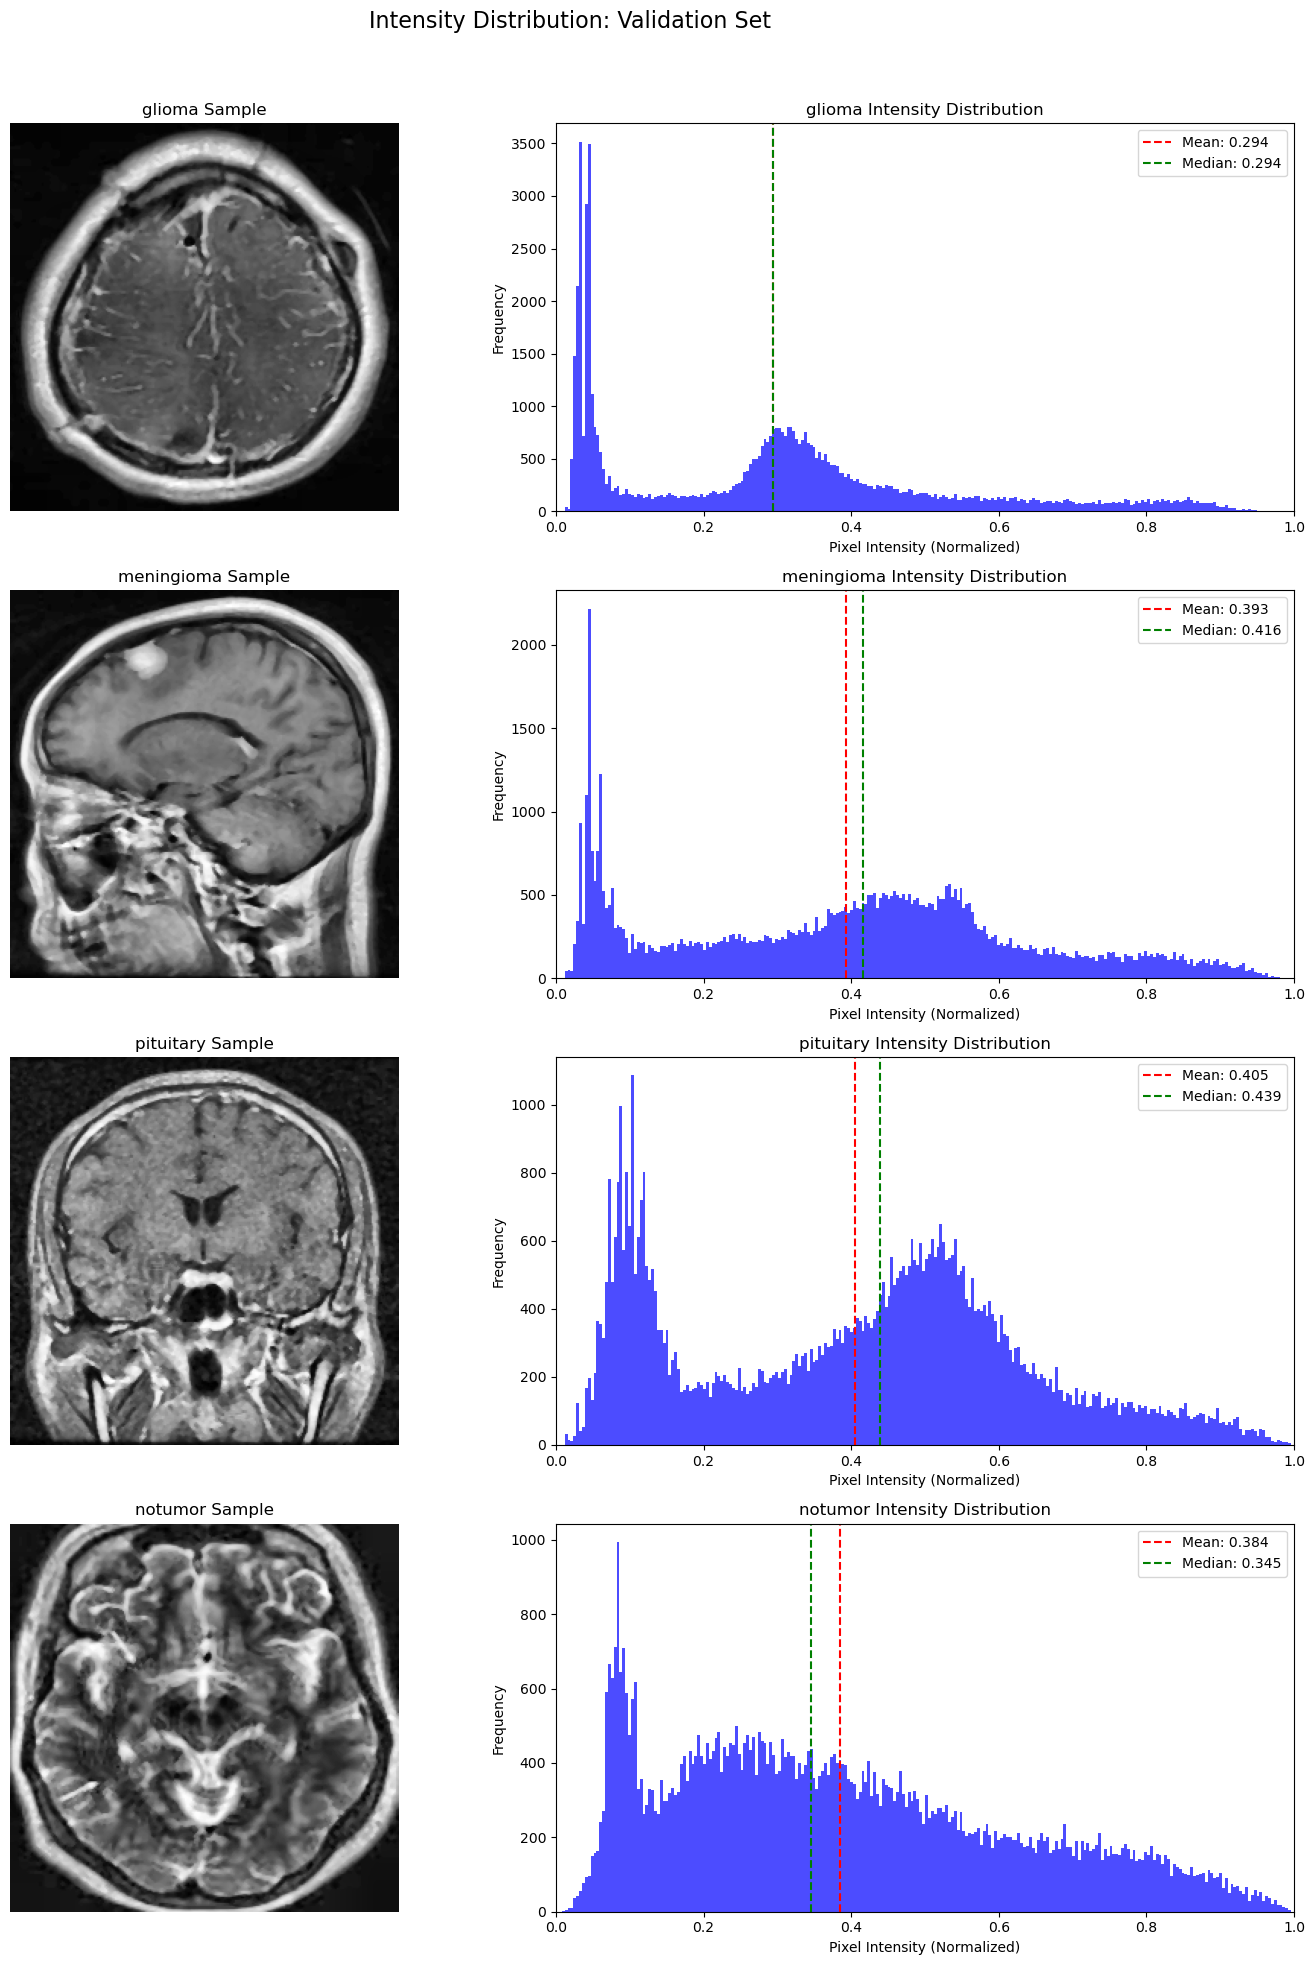


Test Set Intensity Distribution:


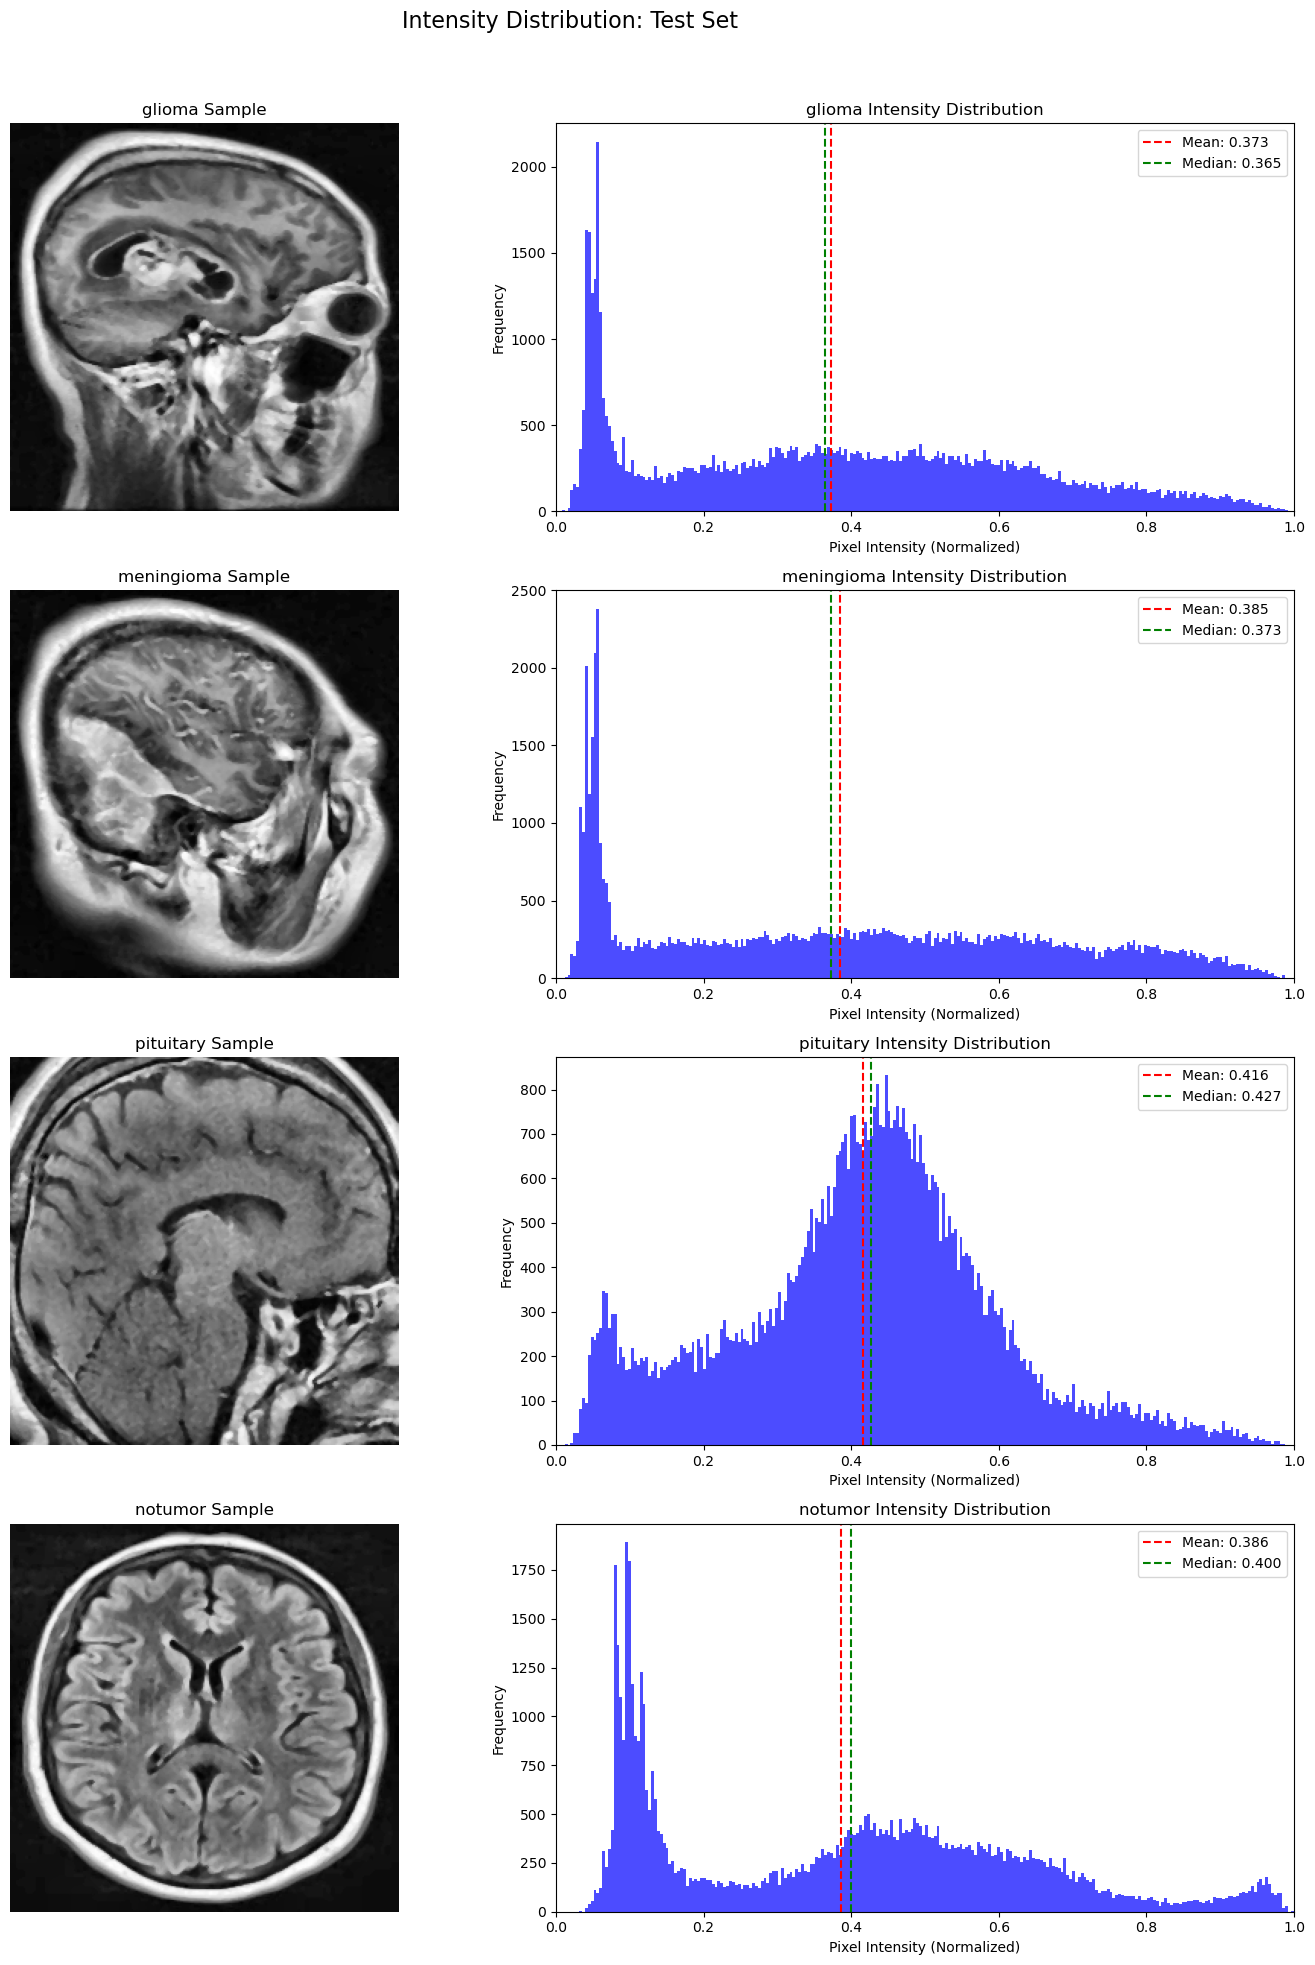


AUGMENTATION QUALITY CHECK


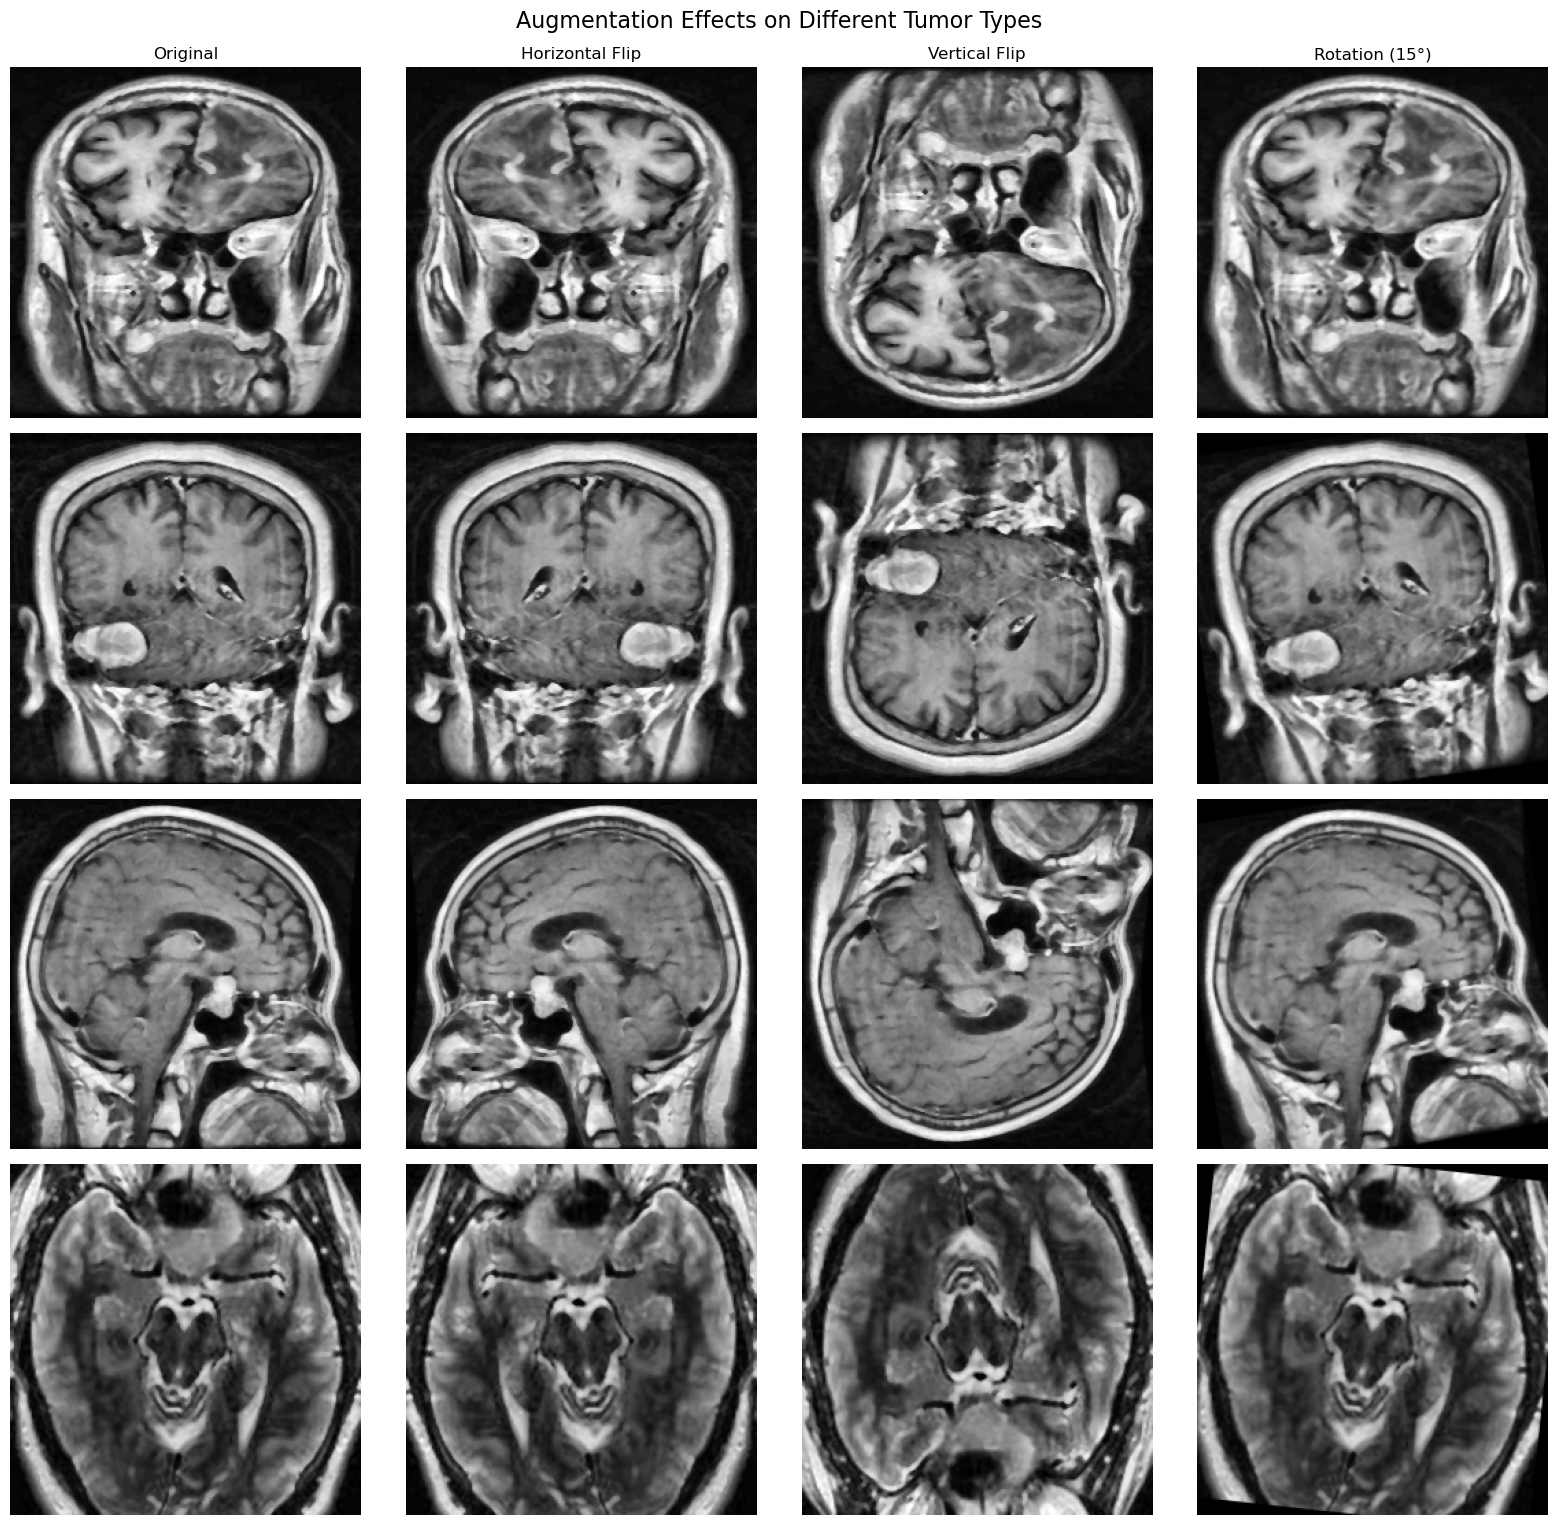

In [3]:
# ====================
# VISUALIZATION FUNCTIONS (FIXED & OPTIMIZED)
# ====================
def plot_samples(images, labels, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)
    indices = np.random.choice(range(len(images)), num_samples)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx][..., 0], cmap='gray')
        class_idx = np.argmax(labels[idx])
        plt.title(f"{LABELS[class_idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_dataset_distribution(Y_train_final, Y_val, Y_test):
    train_counts = np.sum(Y_train_final, axis=0)
    val_counts = np.sum(Y_val, axis=0)
    test_counts = np.sum(Y_test, axis=0)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    width = 0.25
    x = np.arange(len(LABELS))
    
    ax.bar(x - width, train_counts, width, label="Training (Final)", alpha=0.9)
    ax.bar(x, val_counts, width, label="Validation", alpha=0.9)
    ax.bar(x + width, test_counts, width, label="Testing", alpha=0.9)
    
    ax.set_xlabel("Tumor Class", fontsize=12)
    ax.set_ylabel("Number of Images", fontsize=12)
    ax.set_title("Dataset Distribution After Augmentation", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(LABELS, fontsize=11)
    ax.legend(fontsize=11)
    
    for i, v in enumerate(train_counts):
        ax.text(i - width, v + 50, str(int(v)), ha='center', fontsize=9)
    for i, v in enumerate(val_counts):
        ax.text(i, v + 50, str(int(v)), ha='center', fontsize=9)
    for i, v in enumerate(test_counts):
        ax.text(i + width, v + 50, str(int(v)), ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def display_sample_images(images, labels, title, n=4):
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    fig.suptitle(title, fontsize=16, y=1.05)
    
    indices = np.random.choice(range(len(images)), n, replace=False)
    
    for i, idx in enumerate(indices):
        img = images[idx]
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
        axes[i].imshow(img, cmap='gray')
        class_idx = np.argmax(labels[idx])
        axes[i].set_title(f"{LABELS[class_idx]}", fontsize=12)
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_intensity_histograms(images, labels, title):
    # Create a 4x2 grid (4 tumor types, 2 plots per type)
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    fig.suptitle(f"Intensity Distribution: {title}", fontsize=16, y=0.98)
    
    for class_idx, class_name in enumerate(LABELS):
        # Get random sample from this class
        class_indices = np.where(np.argmax(labels, axis=1) == class_idx)[0]
        img = images[np.random.choice(class_indices)]
        
        # Squeeze if single channel
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
        
        # Image plot
        ax_img = axs[class_idx, 0]
        ax_img.imshow(img, cmap='gray')
        ax_img.set_title(f"{class_name} Sample", fontsize=12)
        ax_img.axis('off')
        
        # Histogram plot
        ax_hist = axs[class_idx, 1]
        ax_hist.hist(img.ravel(), bins=256, range=(0, 1), alpha=0.7, color='blue')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_title(f"{class_name} Intensity Distribution", fontsize=12)
        ax_hist.set_xlabel("Pixel Intensity (Normalized)")
        ax_hist.set_ylabel("Frequency")
        
        # Add statistical markers
        mean_val = np.mean(img)
        median_val = np.median(img)
        ax_hist.axvline(x=mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.3f}')
        ax_hist.axvline(x=median_val, color='green', linestyle='--', label=f'Median: {median_val:.3f}')
        ax_hist.legend(fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
    plt.show()

def compare_augmentation_effects(images, labels):
    # Create 4x4 grid (4 tumor types, 4 augmentation types)
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle("Augmentation Effects on Different Tumor Types", fontsize=16, y=0.95)
    
    # Define augmentations to demonstrate
    augmentations = {
        "Original": A.NoOp(),
        "Horizontal Flip": A.HorizontalFlip(p=1),
        "Vertical Flip": A.VerticalFlip(p=1),
        "Rotation (15°)": A.Rotate(limit=15, p=1, border_mode=cv2.BORDER_CONSTANT)
    }
    
    # For each tumor class
    for row_idx, class_name in enumerate(LABELS):
        # Get a random sample of this class
        class_indices = np.where(np.argmax(labels, axis=1) == row_idx)[0]
        orig_img = images[np.random.choice(class_indices)]
        
        # Squeeze if single channel
        if orig_img.shape[-1] == 1:
            orig_img = np.squeeze(orig_img, axis=-1)
        
        # Apply each augmentation
        for col_idx, (aug_name, aug) in enumerate(augmentations.items()):
            augmented = aug(image=orig_img)['image']
            ax = axes[row_idx, col_idx]
            ax.imshow(augmented, cmap='gray')
            
            # Set row and column titles
            if row_idx == 0:
                ax.set_title(aug_name, fontsize=12)
            if col_idx == 0:
                ax.set_ylabel(class_name, fontsize=12)
                
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
    plt.show()

# ====================
# QUALITATIVE ANALYSIS (OPTIMIZED)
# ====================
print("\n" + "="*50)
print("DATASET DISTRIBUTION VISUALIZATION")
print("="*50)
plot_dataset_distribution(Y_train_final, Y_val, Y_test)

print("\n" + "="*50)
print("SAMPLE IMAGE VISUALIZATION")
print("="*50)
print("Final Training Set Samples:")
display_sample_images(X_train_final, Y_train_final, "Final Training Set (Original + Augmented)")

print("\nValidation Set Samples:")
display_sample_images(X_val, Y_val, "Validation Set Samples")

print("\nTest Set Samples:")
display_sample_images(X_test, Y_test, "Test Set Samples")

print("\n" + "="*50)
print("INTENSITY HISTOGRAM ANALYSIS")
print("="*50)
print("Training Set Intensity Distribution:")
plot_intensity_histograms(X_train_final, Y_train_final, "Training Set")

print("\nValidation Set Intensity Distribution:")
plot_intensity_histograms(X_val, Y_val, "Validation Set")

print("\nTest Set Intensity Distribution:")
plot_intensity_histograms(X_test, Y_test, "Test Set")

print("\n" + "="*50)
print("AUGMENTATION QUALITY CHECK")
print("="*50)
# Use original training images before augmentation
compare_augmentation_effects(X_train, Y_train)

In [4]:
from tensorflow import keras
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# ====================
# MODEL ARCHITECTURE
# ====================
def create_optimized_base_model(input_shape=(256, 256, 1)):
    model = keras.models.Sequential([
        # Block 1 - Initial feature extraction
        keras.layers.Conv2D(48, (3, 3), activation='relu', input_shape=input_shape,
                            kernel_regularizer=regularizers.l2(0.005)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(48, (3, 3), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.005)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D((2, 2)),
        
        # Block 2 - Feature consolidation
        keras.layers.Conv2D(96, (3, 3), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.004)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(96, (3, 3), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.004)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D((2, 2)),
        
        # Block 3 - Mid-level features
        keras.layers.Conv2D(192, (3, 3), activation='relu',
                            kernel_regularizer=regularizers.l2(0.003)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(192, (3, 3), activation='relu',
                            kernel_regularizer=regularizers.l2(0.003)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D((2, 2)),
        
        # Block 4 - High-level features (depthwise separable)
        keras.layers.SeparableConv2D(384, (3, 3), activation='relu',
                                     depthwise_regularizer=regularizers.l2(0.002),
                                     pointwise_regularizer=regularizers.l2(0.002)),
        keras.layers.BatchNormalization(),
        keras.layers.SeparableConv2D(384, (3, 3), activation='relu',
                                     depthwise_regularizer=regularizers.l2(0.002),
                                     pointwise_regularizer=regularizers.l2(0.002)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D((2, 2)),
        
        # Block 5 - Final features (depthwise separable)
        keras.layers.SeparableConv2D(512, (3, 3), activation='relu',
                                     depthwise_regularizer=regularizers.l2(0.001),
                                     pointwise_regularizer=regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.SeparableConv2D(512, (3, 3), activation='relu',
                                     depthwise_regularizer=regularizers.l2(0.001),
                                     pointwise_regularizer=regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        
        # Dense layers with optimal capacity
        keras.layers.Dense(512, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.002)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.Dropout(0.4),
        
        # Output
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

# Create model
my_model = create_optimized_base_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 48)      480       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 48)     192       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 48)      20784     
                                                                 
 batch_normalization_1 (Batc  (None, 252, 252, 48)     192       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 48)     0         
 )                                                               
                                                        

In [5]:
# ====================
# LOSS & CALLBACKS
# ====================

# 1. Enable mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print("Mixed precision enabled. Computations will use float16 where possible.")

# 1. Focal Loss Definition
def categorical_focal_loss(gamma=1.5, alpha=0.5):
    def focal_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss

# 2. Model Callbacks
callbacks_list = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    )
]

# ====================
# CLASS WEIGHT CALCULATION
# ====================
# Use original training labels before augmentation
y_train_labels = np.argmax(Y_train, axis=1)

# Compute base class weights
class_weights = compute_class_weight('balanced', 
                                    classes=np.unique(y_train_labels), 
                                    y=y_train_labels)
base_class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Base Class Weights:")
for i, label in enumerate(LABELS):
    print(f"  {label}: {base_class_weights_dict[i]:.4f}")

# Calculate enhanced weights with manual boosting
class_counts = np.sum(Y_train, axis=0)
total = np.sum(class_counts)
enhanced_weights = total / (len(LABELS) * class_counts)

# Apply manual boosting to underperforming classes
enhanced_weights[0] *= 1.3  # Glioma tumor
enhanced_weights[1] *= 1.8  # Meningioma tumor
enhanced_weights_dict = {i: weight for i, weight in enumerate(enhanced_weights)}

print("\nEnhanced Class Weights (with manual boosting):")
for i, label in enumerate(LABELS):
    print(f"  {label}: {enhanced_weights_dict[i]:.4f}")

Mixed precision enabled. Computations will use float16 where possible.
Base Class Weights:
  glioma: 1.0443
  meningioma: 1.0354
  pituitary: 0.9555
  notumor: 0.9709

Enhanced Class Weights (with manual boosting):
  glioma: 1.3576
  meningioma: 1.8637
  pituitary: 0.9555
  notumor: 0.9709


In [6]:
# ====================
# MEMORY-OPTIMIZED DATA PIPELINE
# ====================
print("\nCreating memory-optimized datasets...")

with tf.device("/CPU:0"):
    # Create training dataset
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((X_train_final, Y_train_final))
        .shuffle(2000, reshuffle_each_iteration=True)  # More thorough shuffling
        .batch(32)  # Small batch size to reduce memory pressure
        .cache()  # Cache after batching for better memory efficiency
        .prefetch(tf.data.AUTOTUNE)  # Overlap data preprocessing and model execution
    )
    
    # Create validation dataset
    val_dataset = (
        tf.data.Dataset.from_tensor_slices((X_val, Y_val))
        .batch(32)  # Same batch size as training
        .cache()  # Cache validation batches
        .prefetch(tf.data.AUTOTUNE)
    )

# Memory monitoring callback
class MemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gpu_stats = tf.config.experimental.get_memory_info("GPU:0")
        print(
            f"GPU Memory - Used: {gpu_stats['current']/1e9:.2f}GB, "
            f"Peak: {gpu_stats['peak']/1e9:.2f}GB"
        )


Creating memory-optimized datasets...


In [7]:
# ====================
# ENABLE MIXED PRECISION
# ====================


# ====================
# MODEL COMPILATION
# ====================


import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras import backend as K


policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print("Mixed precision enabled. Computations will use float16 where possible.")

# Wrap optimizer for mixed precision
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
    Adam(learning_rate=0.0002, clipnorm=1.0)
)

# Recompile model with wrapped optimizer
my_model.compile(
    loss=categorical_focal_loss(gamma=1.5, alpha=0.5),
    optimizer=optimizer,
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.AUC(name='auc')]
)

# ====================
# GPU CONFIGURATION
# ====================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

Mixed precision enabled. Computations will use float16 where possible.
Physical devices cannot be modified after being initialized


In [8]:

# Train model with memory optimizations
history = my_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    class_weight=enhanced_weights_dict,
    callbacks=callbacks_list + [MemoryCallback()],
    verbose=1
)

Epoch 1/100
242/242 [==============================] - 137s 434ms/step - loss: 5.0431 - accuracy: 0.7138 - precision: 0.8313 - recall: 0.5444 - auc: 0.9087 - val_loss: 4.5846 - val_accuracy: 0.2414 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4880 - lr: 2.0000e-04
Epoch 2/100
242/242 [==============================] - 96s 395ms/step - loss: 3.7331 - accuracy: 0.8380 - precision: 0.8860 - recall: 0.7543 - auc: 0.9637 - val_loss: 3.6747 - val_accuracy: 0.2396 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5222 - lr: 2.0000e-04
Epoch 3/100
242/242 [==============================] - 96s 397ms/step - loss: 2.8188 - accuracy: 0.8696 - precision: 0.9062 - recall: 0.8190 - auc: 0.9761 - val_loss: 2.5867 - val_accuracy: 0.6282 - val_precision: 0.8286 - val_recall: 0.4231 - val_auc: 0.8388 - lr: 2.0000e-04
Epoch 4/100
242/242 [==============================] - 97s 400ms/step - loss: 2.1135 - accuracy: 0.8922 - precision: 0.9195 - recall: 0.8486 - auc: 0.98


STANDARD EVALUATION (NO TEST-TIME AUGMENTATION)

Test Loss     : 0.0872
Test Accuracy : 94.69%
Test Precision: 0.9523
Test Recall   : 0.9444
Test AUC      : 0.9954
--------------------------------------------------

TEST-TIME AUGMENTATION (TTA) EVALUATION

Evaluating with Batched Test-Time Augmentation...

TTA Performance:
Accuracy : 0.9187 (91.87%)
Precision: 0.9200
Recall   : 0.9187
F1-Score : 0.9184
--------------------------------------------------


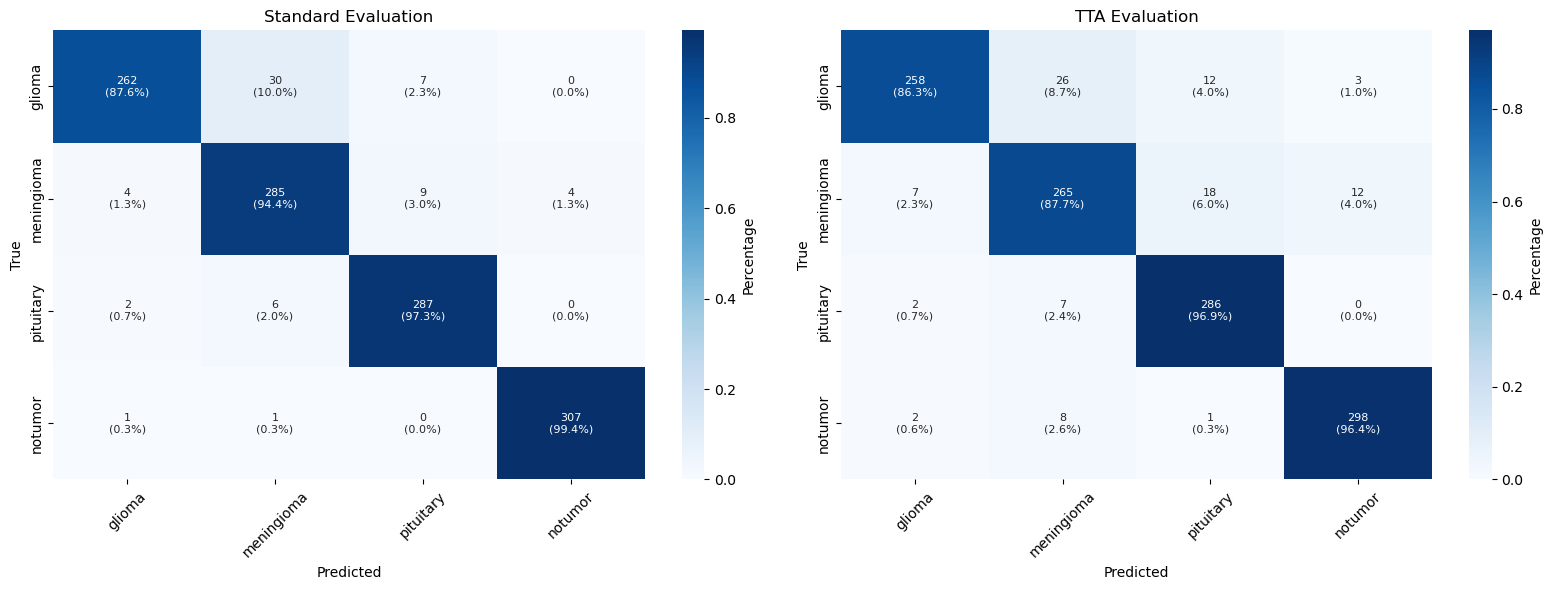


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.9591    0.8629    0.9085       299
  meningioma     0.8660    0.8775    0.8717       302
   pituitary     0.9022    0.9695    0.9346       295
     notumor     0.9521    0.9644    0.9582       309

    accuracy                         0.9187      1205
   macro avg     0.9199    0.9186    0.9183      1205
weighted avg     0.9200    0.9187    0.9184      1205


CLASS-WISE PERFORMANCE SUMMARY
Class                Precision  Recall     F1-Score   Support   
------------------------------------------------------------
glioma               0.9591     0.8629     0.9085     299       
meningioma           0.8660     0.8775     0.8717     302       
pituitary            0.9022     0.9695     0.9346     295       
notumor              0.9521     0.9644     0.9582     309       

PERFORMANCE COMPARISON (Standard vs TTA)
Metric       Standard   TTA        Difference
------------ ---------- ---

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Helper: Plot confusion matrix in a subplot
def plot_cm_subplot(ax, cm, labels, title):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annotations = np.empty_like(cm).astype(str)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percent = cm_normalized[i, j] * 100
            annotations[i, j] = f"{count}\n({percent:.1f}%)"

    sns.heatmap(
        cm_normalized,
        annot=annotations,
        fmt='',
        cmap='Blues',
        ax=ax,
        xticklabels=[label[:12] for label in labels],
        yticklabels=[label[:12] for label in labels],
        cbar_kws={'label': 'Percentage'},
        annot_kws={"size": 8}
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

# ===============================================
# 1. Standard Evaluation
# ===============================================
print("\n" + "="*50)
print("STANDARD EVALUATION (NO TEST-TIME AUGMENTATION)")
print("="*50)

test_loss, test_accuracy, test_precision, test_recall, test_auc = my_model.evaluate(
    X_test, Y_test, verbose=0
)

print(f"\nTest Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy*100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test AUC      : {test_auc:.4f}")
print("-"*50)

# Predictions
y_pred_std = np.argmax(my_model.predict(X_test, verbose=0), axis=1)
y_true = np.argmax(Y_test, axis=1)
cm_std = confusion_matrix(y_true, y_pred_std)

# ===============================================
# 2. TTA Evaluation
# ===============================================
print("\n" + "="*50)
print("TEST-TIME AUGMENTATION (TTA) EVALUATION")
print("="*50)

def predict_with_tta_batched(model, X, batch_size=32, n=5):
    y_pred_tta = []
    num_batches = int(np.ceil(len(X) / batch_size))

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(X))
        batch = X[start_idx:end_idx]

        batch_predictions = []
        for _ in range(n):
            aug = tf.image.random_flip_left_right(batch)
            aug = tf.image.random_flip_up_down(aug)
            aug = tf.image.rot90(aug, k=np.random.randint(0, 4))
            pred = model.predict(aug, verbose=0)
            batch_predictions.append(pred)

        batch_avg = np.mean(batch_predictions, axis=0)
        y_pred_tta.append(batch_avg)

    return np.concatenate(y_pred_tta, axis=0)

print("\nEvaluating with Batched Test-Time Augmentation...")
y_pred_tta = predict_with_tta_batched(my_model, X_test, batch_size=32, n=5)
y_pred_classes = np.argmax(y_pred_tta, axis=1)

# TTA metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nTTA Performance:")
print(f"Accuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("-"*50)

# Confusion Matrix (TTA)
cm_tta = confusion_matrix(y_true, y_pred_classes)

# ===============================================
# Side-by-Side Confusion Matrices
# ===============================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plot_cm_subplot(axs[0], cm_std, LABELS, title='Standard Evaluation')
plot_cm_subplot(axs[1], cm_tta, LABELS, title='TTA Evaluation')
plt.tight_layout()
plt.show()

# ===============================================
# 3. Classification Report
# ===============================================
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred_classes, target_names=LABELS, digits=4))

# ===============================================
# 4. Class-wise Performance Breakdown
# ===============================================
print("\n" + "="*50)
print("CLASS-WISE PERFORMANCE SUMMARY")
print("="*50)

precision_per_class = precision_score(y_true, y_pred_classes, average=None)
recall_per_class = recall_score(y_true, y_pred_classes, average=None)
f1_per_class = f1_score(y_true, y_pred_classes, average=None)

print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 60)
for i, label in enumerate(LABELS):
    support = np.sum(y_true == i)
    print(f"{label:<20} {precision_per_class[i]:<10.4f} {recall_per_class[i]:<10.4f} {f1_per_class[i]:<10.4f} {support:<10}")

# ===============================================
# 5. Performance Comparison
# ===============================================
print("\n" + "="*50)
print("PERFORMANCE COMPARISON (Standard vs TTA)")
print("="*50)
print(f"{'Metric':<12} {'Standard':<10} {'TTA':<10} {'Difference':<10}")
print(f"{'-'*12} {'-'*10} {'-'*10} {'-'*10}")
print(f"{'Accuracy':<12} {test_accuracy:.4f}    {accuracy:.4f}    {accuracy - test_accuracy:+.4f}")
print(f"{'Precision':<12} {test_precision:.4f}    {precision:.4f}    {precision - test_precision:+.4f}")
print(f"{'Recall':<12} {test_recall:.4f}    {recall:.4f}    {recall - test_recall:+.4f}")

# ===============================================
# 6. Error Analysis
# ===============================================
print("\n" + "="*50)
print("TOP ERROR ANALYSIS")
print("="*50)

for i, label in enumerate(LABELS):
    misclassified = np.where((y_pred_classes != y_true) & (y_true == i))[0]
    if len(misclassified) > 0:
        wrong_preds = y_pred_classes[misclassified]
        top_error = np.bincount(wrong_preds).argmax()
        error_count = np.sum(wrong_preds == top_error)
        print(f"{label} -> {LABELS[top_error]}: {error_count}/{len(misclassified)} errors")


In [10]:
# ====================
# PHASE 2 FINE-TUNING
# ====================
print("\nStarting Phase 2: Fine-tuning...")

# Unfreeze deeper layers
unfreeze_count = 0
for layer in my_model.layers[-10:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
        unfreeze_count += 1
print(f"Unfrozen {unfreeze_count} layers for fine-tuning")

# Recompile with lower learning rate
my_model.compile(
    loss=categorical_focal_loss(gamma=1.5, alpha=0.5),
    optimizer=Adam(learning_rate=0.00005),
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.AUC(name='auc')]
)

# Create data generator
def data_generator(features, labels, batch_size=16):
    num_samples = len(features)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            if len(batch_indices) == 0:
                continue
            batch_features = features[batch_indices]
            batch_labels = labels[batch_indices]
            yield batch_features, batch_labels

# Calculate steps per epoch
batch_size = 16
steps_per_epoch = max(1, len(X_train_final) // batch_size)

# Fine-tune model
print("\nStarting fine-tuning with generator-based dataset...")
history_fine = my_model.fit(
    data_generator(X_train_final, Y_train_final, batch_size),
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=30,
    class_weight=enhanced_weights_dict,
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        )
    ],
    verbose=1
)



Starting Phase 2: Fine-tuning...
Unfrozen 8 layers for fine-tuning

Starting fine-tuning with generator-based dataset...
Epoch 1/30
483/483 [==============================] - 121s 240ms/step - loss: 0.0825 - accuracy: 0.9563 - precision: 0.9659 - recall: 0.9422 - auc: 0.9968 - val_loss: 0.1248 - val_accuracy: 0.8986 - val_precision: 0.9105 - val_recall: 0.8902 - val_auc: 0.9875 - lr: 5.0000e-05
Epoch 2/30
483/483 [==============================] - 130s 269ms/step - loss: 0.0743 - accuracy: 0.9683 - precision: 0.9773 - recall: 0.9569 - auc: 0.9981 - val_loss: 0.0998 - val_accuracy: 0.9348 - val_precision: 0.9418 - val_recall: 0.9270 - val_auc: 0.9928 - lr: 5.0000e-05
Epoch 3/30
483/483 [==============================] - 135s 279ms/step - loss: 0.0763 - accuracy: 0.9660 - precision: 0.9727 - recall: 0.9577 - auc: 0.9979 - val_loss: 0.1223 - val_accuracy: 0.9173 - val_precision: 0.9246 - val_recall: 0.9028 - val_auc: 0.9866 - lr: 5.0000e-05
Epoch 4/30
483/483 [===========================

In [11]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_auc = my_model.evaluate(X_test, Y_test)

# Print test results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test AUC: {test_auc:.2f}")

38/38 [==============================] - 6s 144ms/step - loss: 0.0849 - accuracy: 0.9568 - precision: 0.9607 - recall: 0.9527 - auc: 0.9963
Test Accuracy: 95.68%
Test Precision: 0.96
Test Recall: 0.95
Test AUC: 1.00



STANDARD EVALUATION (NO TEST-TIME AUGMENTATION)

Test Loss     : 0.0849
Test Accuracy : 95.68%
Test Precision: 0.9607
Test Recall   : 0.9527
Test AUC      : 0.9963
--------------------------------------------------

TEST-TIME AUGMENTATION (TTA) EVALUATION

Evaluating with Batched Test-Time Augmentation...

TTA Performance:
Accuracy : 0.9245 (92.45%)
Precision: 0.9251
Recall   : 0.9245
F1-Score : 0.9242
--------------------------------------------------


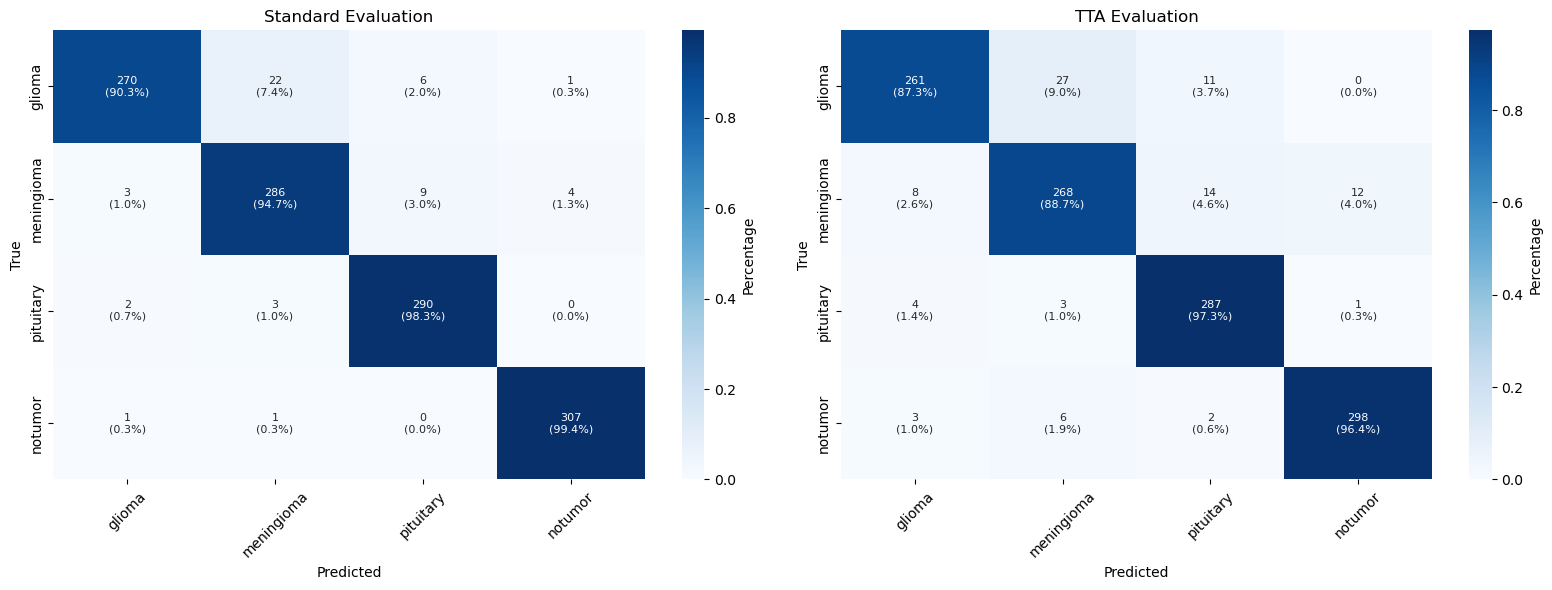


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.9457    0.8729    0.9078       299
  meningioma     0.8816    0.8874    0.8845       302
   pituitary     0.9140    0.9729    0.9425       295
     notumor     0.9582    0.9644    0.9613       309

    accuracy                         0.9245      1205
   macro avg     0.9249    0.9244    0.9240      1205
weighted avg     0.9251    0.9245    0.9242      1205


CLASS-WISE PERFORMANCE SUMMARY
Class                Precision  Recall     F1-Score   Support   
------------------------------------------------------------
glioma               0.9457     0.8729     0.9078     299       
meningioma           0.8816     0.8874     0.8845     302       
pituitary            0.9140     0.9729     0.9425     295       
notumor              0.9582     0.9644     0.9613     309       

PERFORMANCE COMPARISON (Standard vs TTA)
Metric       Standard   TTA        Difference
------------ ---------- ---

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Helper: Plot confusion matrix in a subplot
def plot_cm_subplot(ax, cm, labels, title):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annotations = np.empty_like(cm).astype(str)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percent = cm_normalized[i, j] * 100
            annotations[i, j] = f"{count}\n({percent:.1f}%)"

    sns.heatmap(
        cm_normalized,
        annot=annotations,
        fmt='',
        cmap='Blues',
        ax=ax,
        xticklabels=[label[:12] for label in labels],
        yticklabels=[label[:12] for label in labels],
        cbar_kws={'label': 'Percentage'},
        annot_kws={"size": 8}
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

# ===============================================
# 1. Standard Evaluation
# ===============================================
print("\n" + "="*50)
print("STANDARD EVALUATION (NO TEST-TIME AUGMENTATION)")
print("="*50)

test_loss, test_accuracy, test_precision, test_recall, test_auc = my_model.evaluate(
    X_test, Y_test, verbose=0
)

print(f"\nTest Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy*100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test AUC      : {test_auc:.4f}")
print("-"*50)

# Predictions
y_pred_std = np.argmax(my_model.predict(X_test, verbose=0), axis=1)
y_true = np.argmax(Y_test, axis=1)
cm_std = confusion_matrix(y_true, y_pred_std)

# ===============================================
# 2. TTA Evaluation
# ===============================================
print("\n" + "="*50)
print("TEST-TIME AUGMENTATION (TTA) EVALUATION")
print("="*50)

def predict_with_tta_batched(model, X, batch_size=32, n=5):
    y_pred_tta = []
    num_batches = int(np.ceil(len(X) / batch_size))

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(X))
        batch = X[start_idx:end_idx]

        batch_predictions = []
        for _ in range(n):
            aug = tf.image.random_flip_left_right(batch)
            aug = tf.image.random_flip_up_down(aug)
            aug = tf.image.rot90(aug, k=np.random.randint(0, 4))
            pred = model.predict(aug, verbose=0)
            batch_predictions.append(pred)

        batch_avg = np.mean(batch_predictions, axis=0)
        y_pred_tta.append(batch_avg)

    return np.concatenate(y_pred_tta, axis=0)

print("\nEvaluating with Batched Test-Time Augmentation...")
y_pred_tta = predict_with_tta_batched(my_model, X_test, batch_size=32, n=5)
y_pred_classes = np.argmax(y_pred_tta, axis=1)

# TTA metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nTTA Performance:")
print(f"Accuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("-"*50)

# Confusion Matrix (TTA)
cm_tta = confusion_matrix(y_true, y_pred_classes)

# ===============================================
# Side-by-Side Confusion Matrices
# ===============================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plot_cm_subplot(axs[0], cm_std, LABELS, title='Standard Evaluation')
plot_cm_subplot(axs[1], cm_tta, LABELS, title='TTA Evaluation')
plt.tight_layout()
plt.show()

# ===============================================
# 3. Classification Report
# ===============================================
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred_classes, target_names=LABELS, digits=4))

# ===============================================
# 4. Class-wise Performance Breakdown
# ===============================================
print("\n" + "="*50)
print("CLASS-WISE PERFORMANCE SUMMARY")
print("="*50)

precision_per_class = precision_score(y_true, y_pred_classes, average=None)
recall_per_class = recall_score(y_true, y_pred_classes, average=None)
f1_per_class = f1_score(y_true, y_pred_classes, average=None)

print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 60)
for i, label in enumerate(LABELS):
    support = np.sum(y_true == i)
    print(f"{label:<20} {precision_per_class[i]:<10.4f} {recall_per_class[i]:<10.4f} {f1_per_class[i]:<10.4f} {support:<10}")

# ===============================================
# 5. Performance Comparison
# ===============================================
print("\n" + "="*50)
print("PERFORMANCE COMPARISON (Standard vs TTA)")
print("="*50)
print(f"{'Metric':<12} {'Standard':<10} {'TTA':<10} {'Difference':<10}")
print(f"{'-'*12} {'-'*10} {'-'*10} {'-'*10}")
print(f"{'Accuracy':<12} {test_accuracy:.4f}    {accuracy:.4f}    {accuracy - test_accuracy:+.4f}")
print(f"{'Precision':<12} {test_precision:.4f}    {precision:.4f}    {precision - test_precision:+.4f}")
print(f"{'Recall':<12} {test_recall:.4f}    {recall:.4f}    {recall - test_recall:+.4f}")

# ===============================================
# 6. Error Analysis
# ===============================================
print("\n" + "="*50)
print("TOP ERROR ANALYSIS")
print("="*50)

for i, label in enumerate(LABELS):
    misclassified = np.where((y_pred_classes != y_true) & (y_true == i))[0]
    if len(misclassified) > 0:
        wrong_preds = y_pred_classes[misclassified]
        top_error = np.bincount(wrong_preds).argmax()
        error_count = np.sum(wrong_preds == top_error)
        print(f"{label} -> {LABELS[top_error]}: {error_count}/{len(misclassified)} errors")



PHASE 1: INITIAL TRAINING METRICS


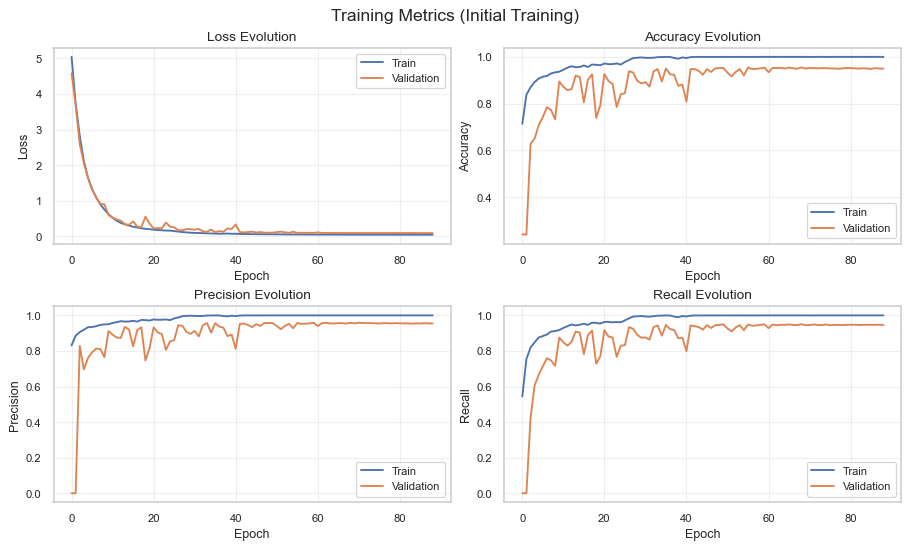


PHASE 2: FINE-TUNING METRICS


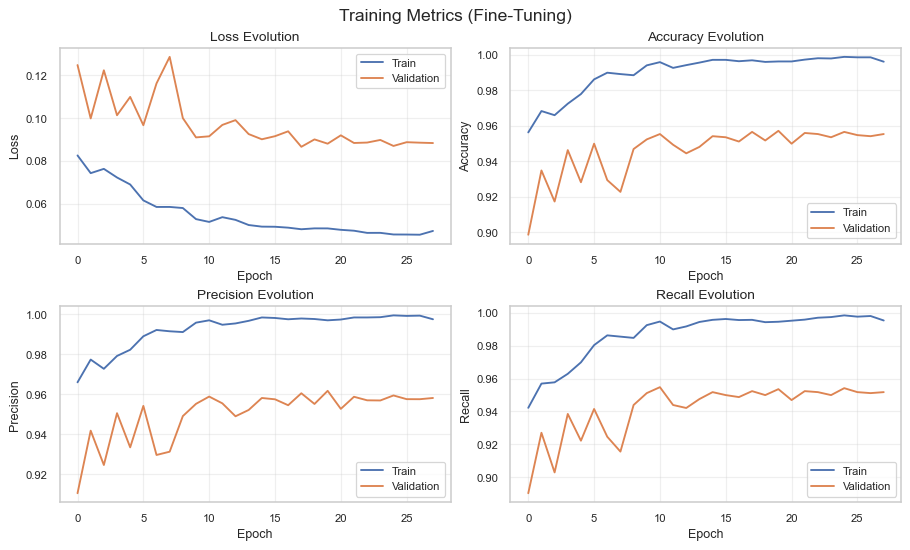

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    accuracy_score, precision_score, recall_score, 
    f1_score, precision_recall_fscore_support,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize

# Global styling
sns.set(style='whitegrid', font_scale=1.05)
plt.rcParams.update({
    'figure.dpi': 90,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})

# ==============================================================================
# 1. TRAINING HISTORY VISUALIZATION
# ==============================================================================
def plot_training_history(history, title_suffix=""):
    """Compact training curve display."""
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
    fig.suptitle(f'Training Metrics {title_suffix}', fontsize=14)

    metrics = {
        'Loss': ('loss', 'val_loss'),
        'Accuracy': ('accuracy', 'val_accuracy'),
        'Precision': ('precision', 'val_precision'),
        'Recall': ('recall', 'val_recall')
    }

    for ax, (title, (train_key, val_key)) in zip(axs.flat, metrics.items()):
        ax.plot(history.history.get(train_key, []), label='Train', lw=1.5)
        ax.plot(history.history.get(val_key, []), label='Validation', lw=1.5)
        ax.set_title(f'{title} Evolution')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.grid(True, alpha=0.3)
        ax.legend()

    return fig

# ==============================================================================
# 2. DISPLAY TRAINING HISTORY
# ==============================================================================
print("\n" + "="*60)
print("PHASE 1: INITIAL TRAINING METRICS")
print("="*60)
plot_training_history(history, "(Initial Training)")
plt.show()

print("\n" + "="*60)
print("PHASE 2: FINE-TUNING METRICS")
print("="*60)
plot_training_history(history_fine, "(Fine-Tuning)")
plt.show()

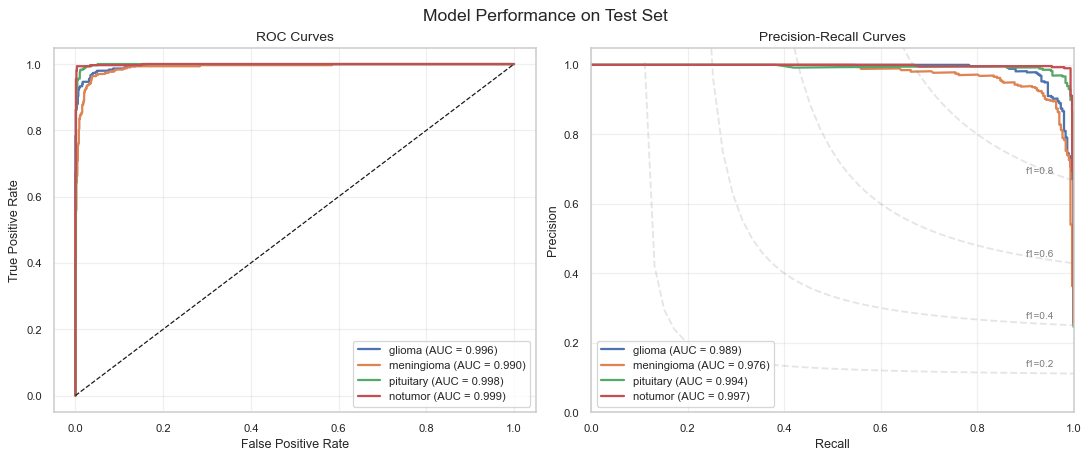

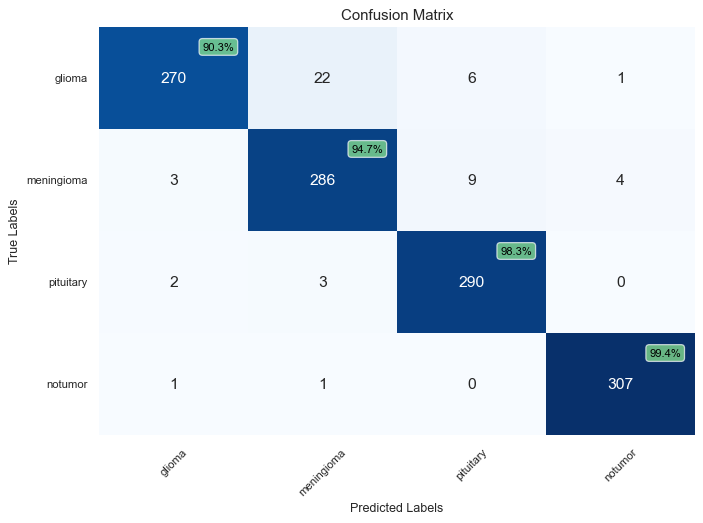


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.98      0.90      0.94       299
  meningioma       0.92      0.95      0.93       302
   pituitary       0.95      0.98      0.97       295
     notumor       0.98      0.99      0.99       309

    accuracy                           0.96      1205
   macro avg       0.96      0.96      0.96      1205
weighted avg       0.96      0.96      0.96      1205


TOP MISCLASSIFICATION PATTERNS
glioma -> meningioma: 22 errors
meningioma -> pituitary: 9 errors
glioma -> pituitary: 6 errors
meningioma -> notumor: 4 errors
meningioma -> glioma: 3 errors


In [14]:
# First, compute predictions and true labels
y_pred = my_model.predict(X_test, verbose=0)
y_true = np.argmax(Y_test, axis=1)  # Convert one-hot to class indices

# Now proceed with the visualization code
n_classes = len(LABELS)
y_test_bin = label_binarize(y_true, classes=range(n_classes))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# ROC Curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, lw=1.8, label=f'{LABELS[i]} (AUC = {roc_auc:.3f})')

axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0].set_title('ROC Curves')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc='lower right')
axs[0].grid(alpha=0.3)

# PR Curve
for i in range(n_classes):
    precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    pr_auc = auc(recall_curve, precision_curve)
    axs[1].plot(recall_curve, precision_curve, lw=1.8, label=f'{LABELS[i]} (AUC = {pr_auc:.3f})')

# Add iso-f1 curves
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    axs[1].plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2, linestyle='--')
    axs[1].annotate(f"f1={f_score:.1f}", xy=(0.9, y[-1] + 0.02), fontsize=8, alpha=0.6)

axs[1].set_title('Precision-Recall Curves')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].legend(loc='lower left')
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlim([0.0, 1.0])
axs[1].grid(alpha=0.3)

plt.suptitle('Model Performance on Test Set', fontsize=14)
plt.show()

# ==============================================================================
# 4. CONFUSION MATRIX VISUALIZATION
# ==============================================================================
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=LABELS, 
            yticklabels=LABELS,
            cbar=False)

plt.title('Confusion Matrix', fontsize=12)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Add accuracy annotations
for i in range(len(LABELS)):
    accuracy = cm[i,i] / cm[i].sum()
    plt.text(i+0.8, i+0.2, f'{accuracy:.1%}', 
             ha='center', va='center', 
             color='black' if accuracy > 0.5 else 'white',
             fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', 
                       facecolor=('white' if accuracy < 0.7 else 'lightgreen'), 
                       alpha=0.7))

plt.tight_layout()
plt.show()

# ==============================================================================
# 5. CLASSIFICATION REPORT
# ==============================================================================
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred_classes, target_names=LABELS))

# ==============================================================================
# 6. ERROR ANALYSIS - TOP MISCLASSIFICATIONS
# ==============================================================================
error_indices = np.where(y_true != y_pred_classes)[0]
error_samples = []
for idx in error_indices:
    true_label = LABELS[y_true[idx]]
    pred_label = LABELS[y_pred_classes[idx]]
    error_samples.append((true_label, pred_label, idx))

error_counts = {}
for true, pred, _ in error_samples:
    key = f"{true} -> {pred}"
    error_counts[key] = error_counts.get(key, 0) + 1

# Sort by frequency
sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n" + "="*60)
print("TOP MISCLASSIFICATION PATTERNS")
print("="*60)
for pattern, count in sorted_errors:
    print(f"{pattern}: {count} errors")

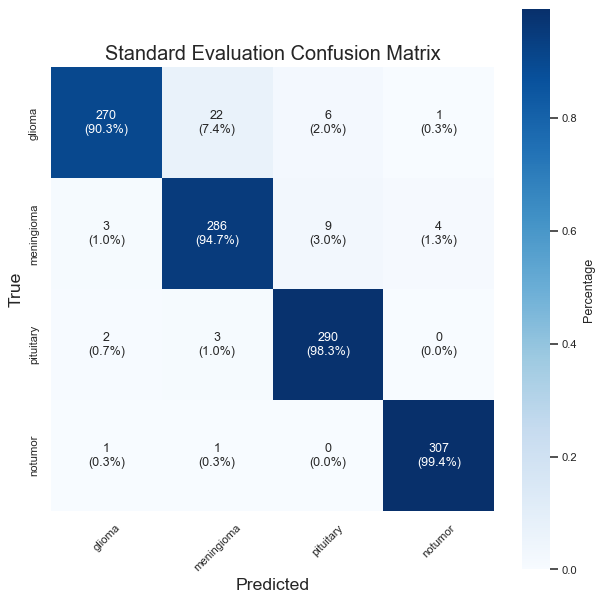

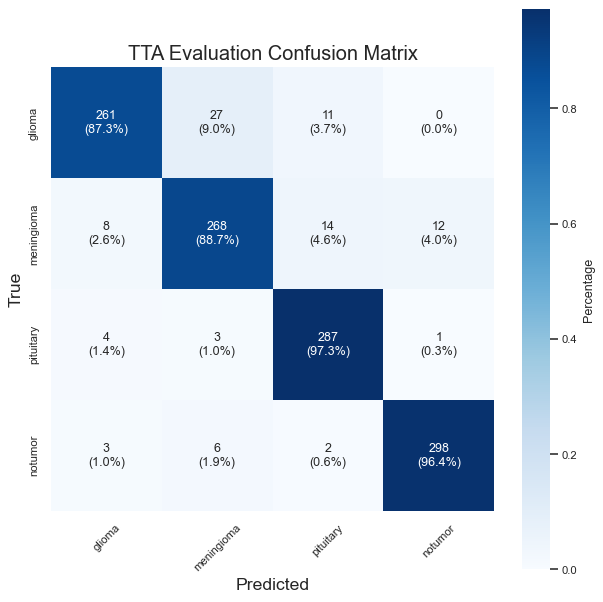

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cm_subplot(ax, cm, labels, title):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annotations = np.empty_like(cm).astype(str)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percent = cm_normalized[i, j] * 100
            annotations[i, j] = f"{count}\n({percent:.1f}%)"

    sns.heatmap(
        cm_normalized,
        annot=annotations,
        fmt='',
        cmap='Blues',
        ax=ax,
        xticklabels=[label[:12] for label in labels],
        yticklabels=[label[:12] for label in labels],
        cbar_kws={'label': 'Percentage'},
        annot_kws={"size": 10},
        square=True  # <-- keep cells square
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('True', fontsize=14)
    ax.tick_params(axis='x', rotation=45)

# Plot confusion matrix with square cells and reasonable size
fig, ax = plt.subplots(figsize=(7, 7))
plot_cm_subplot(ax, cm_std, LABELS, title='Standard Evaluation Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot TTA confusion matrix with the same style
fig, ax = plt.subplots(figsize=(7, 7))
plot_cm_subplot(ax, cm_tta, LABELS, title='TTA Evaluation Confusion Matrix')
plt.tight_layout()
plt.show()
